<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 13.3 MB/s eta 0:00:00


In [3]:
! pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.3 MB/s eta 0:00:00


In [ ]:
!python -m spacy download en_core_web_sm

In [42]:
# Essential Libraries
import re
import spacy
import praw
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import asyncpraw
import seaborn as sns

# NLP & Sentiment Analysis
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
from wordcloud import WordCloud

# NLTK Downloads (only necessary ones)
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [43]:
# Initialize Reddit API
reddit = asyncpraw.Reddit(
    client_id="ZRSYUiHRJOl_3XR_6ifWwQ",
    client_secret="CEeasW1hnMozmDPGh8YXBUZMN6jV9Q",
    user_agent="BitcoinScraper"
)

In [82]:
import asyncpraw
import pandas as pd
import asyncio
import time
from datetime import datetime
import nest_asyncio

# Apply workaround for Jupyter Notebook
nest_asyncio.apply()

# 🔹 List of subreddits
subreddits = ["Bitcoin", "cryptocurrency", "btc", "BitcoinMarkets", "CryptoCurrencyTrading"]

# 🔹 Store data
posts = []
post_limit = 1000  # Max posts per category

async def fetch_posts():
    global posts
    for sub in subreddits:
        subreddit = await reddit.subreddit(sub)

        # Fetch from multiple categories to get diverse data
        categories = {
            "hot": subreddit.hot(limit=post_limit),
            "new": subreddit.new(limit=post_limit),
            "top": subreddit.top(time_filter="month", limit=post_limit)
        }

        for category, fetcher in categories.items():
            count = 0
            async for post in fetcher:
                posts.append([
                    sub,
                    category,  # Hot, New, or Top
                    post.title,
                    post.url,
                    post.score,
                    post.num_comments,
                    datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S')
                ])
                count += 1

                # Avoid Reddit rate limits
                if count % 200 == 0:
                    print(f"⏳ Processed {count} posts from r/{sub} ({category})... Sleeping to avoid rate limit")
                    await asyncio.sleep(5)  # Async sleep

async def main():
    await fetch_posts()

    # 🔹 Convert to DataFrame
    df = pd.DataFrame(posts, columns=["Subreddit", "Category", "Title", "URL", "Upvotes", "Comments", "Timestamp"])

    # 🔹 Save to CSV
    df.to_csv("reddit_crypto_data.csv", index=False)
    print(f"✅ Data saved to reddit_crypto_data.csv ({len(df)} posts)")

# Run in Jupyter-friendly way
await main()

⏳ Processed 200 posts from r/Bitcoin (hot)... Sleeping to avoid rate limit
⏳ Processed 400 posts from r/Bitcoin (hot)... Sleeping to avoid rate limit
⏳ Processed 600 posts from r/Bitcoin (hot)... Sleeping to avoid rate limit
⏳ Processed 200 posts from r/Bitcoin (new)... Sleeping to avoid rate limit
⏳ Processed 400 posts from r/Bitcoin (new)... Sleeping to avoid rate limit
⏳ Processed 600 posts from r/Bitcoin (new)... Sleeping to avoid rate limit
⏳ Processed 800 posts from r/Bitcoin (new)... Sleeping to avoid rate limit
⏳ Processed 200 posts from r/Bitcoin (top)... Sleeping to avoid rate limit
⏳ Processed 400 posts from r/Bitcoin (top)... Sleeping to avoid rate limit
⏳ Processed 600 posts from r/Bitcoin (top)... Sleeping to avoid rate limit
⏳ Processed 800 posts from r/Bitcoin (top)... Sleeping to avoid rate limit
⏳ Processed 1000 posts from r/Bitcoin (top)... Sleeping to avoid rate limit
⏳ Processed 200 posts from r/cryptocurrency (hot)... Sleeping to avoid rate limit
⏳ Processed 200 p

In [83]:
#load data
df = pd.read_csv("/content/reddit_crypto_data.csv")
df.head()

,Subreddit,Category,Title,URL,Upvotes,Comments,Timestamp
0,Bitcoin,hot,Bitcoin Newcomers FAQ - Please read!,https://www.reddit.com/r/Bitcoin/comments/1f7n...,129,32,2024-09-03 01:05:33
1,Bitcoin,hot,"Daily Discussion, February 12, 2025",https://www.reddit.com/r/Bitcoin/comments/1ink...,5,7,2025-02-12 06:02:16
2,Bitcoin,hot,HISTORY: 🟠 Henry Ford predicted that an “energ...,https://i.redd.it/3k4ydxgfbnie1.png,206,39,2025-02-12 05:41:05
3,Bitcoin,hot,Bitcoin,https://i.redd.it/e3q9o9jtknie1.jpeg,144,7,2025-02-12 06:33:37
4,Bitcoin,hot,Please Send me a Sign 🙏🏼,https://i.redd.it/q0p91xmj0mie1.jpeg,359,31,2025-02-12 01:18:11


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8787 entries, 0 to 8786
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subreddit  8787 non-null   object
 1   Category   8787 non-null   object
 2   Title      8787 non-null   object
 3   URL        8787 non-null   object
 4   Upvotes    8787 non-null   int64 
 5   Comments   8787 non-null   int64 
 6   Timestamp  8787 non-null   object
dtypes: int64(2), object(5)
memory usage: 480.7+ KB


In [85]:
df = df.drop(columns=["URL"])
print(df.head())  # Confirm removal

  Subreddit Category                                              Title  \
0   Bitcoin      hot               Bitcoin Newcomers FAQ - Please read!   
1   Bitcoin      hot                Daily Discussion, February 12, 2025   
2   Bitcoin      hot  HISTORY: 🟠 Henry Ford predicted that an “energ...   
3   Bitcoin      hot                                            Bitcoin   
4   Bitcoin      hot                           Please Send me a Sign 🙏🏼   

   Upvotes  Comments            Timestamp  
0      129        32  2024-09-03 01:05:33  
1        5         7  2025-02-12 06:02:16  
2      206        39  2025-02-12 05:41:05  
3      144         7  2025-02-12 06:33:37  
4      359        31  2025-02-12 01:18:11  


In [86]:
df['Date'] = pd.to_datetime(df['Timestamp'])
print(df['Date'].min(), "to", df['Date'].max())

2020-11-11 11:31:38 to 2025-02-12 08:27:14


In [87]:
df = df.sort_values(by="Date")
print(df.head())  # show the earliest dates

           Subreddit Category  \
4780             btc      hot   
7989  BitcoinMarkets      new   
7988  BitcoinMarkets      new   
7987  BitcoinMarkets      new   
7986  BitcoinMarkets      new   

                                                  Title  Upvotes  Comments  \
4780  Frequently Asked Questions and Information Thread      640      1837   
7989       [Daily Discussion] - Sunday, August 27, 2023       26        40   
7988       [Daily Discussion] - Monday, August 28, 2023       23        43   
7987      [Daily Discussion] - Tuesday, August 29, 2023       33       198   
7986    [Daily Discussion] - Wednesday, August 30, 2023       27        78   

                Timestamp                Date  
4780  2020-11-11 11:31:38 2020-11-11 11:31:38  
7989  2023-08-27 04:01:01 2023-08-27 04:01:01  
7988  2023-08-28 04:01:33 2023-08-28 04:01:33  
7987  2023-08-29 04:00:19 2023-08-29 04:00:19  
7986  2023-08-30 04:00:39 2023-08-30 04:00:39  


In [88]:
#delete the first row
df = df.iloc[1:]
print(df.head())

           Subreddit Category  \
7989  BitcoinMarkets      new   
7988  BitcoinMarkets      new   
7987  BitcoinMarkets      new   
7986  BitcoinMarkets      new   
7985  BitcoinMarkets      new   

                                                Title  Upvotes  Comments  \
7989     [Daily Discussion] - Sunday, August 27, 2023       26        40   
7988     [Daily Discussion] - Monday, August 28, 2023       23        43   
7987    [Daily Discussion] - Tuesday, August 29, 2023       33       198   
7986  [Daily Discussion] - Wednesday, August 30, 2023       27        78   
7985   [Daily Discussion] - Thursday, August 31, 2023       28       137   

                Timestamp                Date  
7989  2023-08-27 04:01:01 2023-08-27 04:01:01  
7988  2023-08-28 04:01:33 2023-08-28 04:01:33  
7987  2023-08-29 04:00:19 2023-08-29 04:00:19  
7986  2023-08-30 04:00:39 2023-08-30 04:00:39  
7985  2023-08-31 04:00:41 2023-08-31 04:00:41  


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8786 entries, 7989 to 45
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Subreddit  8786 non-null   object        
 1   Category   8786 non-null   object        
 2   Title      8786 non-null   object        
 3   Upvotes    8786 non-null   int64         
 4   Comments   8786 non-null   int64         
 5   Timestamp  8786 non-null   object        
 6   Date       8786 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 549.1+ KB


In [90]:
# Compute the difference between consecutive dates
df['Date_Diff'] = df['Date'].diff().dt.days

# Check if all differences are 1 day
is_continuous = (df['Date_Diff'].iloc[1:] == 1).all()

print("Are the dates continuous?", is_continuous)

Are the dates continuous? False


In [91]:
print(df[['Date', 'Date_Diff']])

                    Date  Date_Diff
7989 2023-08-27 04:01:01        NaN
7988 2023-08-28 04:01:33        1.0
7987 2023-08-29 04:00:19        0.0
7986 2023-08-30 04:00:39        1.0
7985 2023-08-31 04:00:41        1.0
...                  ...        ...
2973 2025-02-12 08:06:44        0.0
760  2025-02-12 08:19:13        0.0
37   2025-02-12 08:19:13        0.0
759  2025-02-12 08:27:14        0.0
45   2025-02-12 08:27:14        0.0

[8786 rows x 2 columns]


In [92]:
#Drop Timestamp
df = df.drop(columns=["Timestamp"])

In [93]:
print(df["Subreddit"].unique())

['BitcoinMarkets' 'CryptoCurrencyTrading' 'btc' 'Bitcoin' 'cryptocurrency']


## Data Preprocessing

### 🧹 **Text Cleaning & Preprocessing**  

#### ✅ **Steps Taken:**  
1️⃣ **Removed Mentions** (`@username`) – Eliminates user tags for cleaner analysis.  
2️⃣ **Removed URLs** (`http://example.com`) – Removes links to avoid external influence.  
3️⃣ **Removed Special Characters & Extra Spaces** – Keeps only letters and spaces.  
4️⃣ **Converted to Lowercase** – Ensures consistency in text formatting.  
5️⃣ **Tokenized Text** – Splits sentences into individual words for processing.  
6️⃣ **Lemmatized Words** – Converts words to their base form (e.g., "running" → "run").  
7️⃣ **Removed Stopwords**  – Filters out common words like "the," "is," etc.  

In [94]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase & strip whitespace

    # Tokenization, lemmatization & stopword removal
    doc = nlp(text)
    cleaned_tokens = [token.lemma_ for token in doc if token.text not in STOP_WORDS]

    return " ".join(cleaned_tokens)  # Return cleaned text as a string

# Apply cleaning function
df["cleaned_text"] = df["Title"].astype(str).apply(clean_text)  # Assuming "Title" holds the text

df.head()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


,Subreddit,Category,Title,Upvotes,Comments,Date,Date_Diff,cleaned_text
7989,BitcoinMarkets,new,"[Daily Discussion] - Sunday, August 27, 2023",26,40,2023-08-27 04:01:01,NaN,daily discussion sunday august
7988,BitcoinMarkets,new,"[Daily Discussion] - Monday, August 28, 2023",23,43,2023-08-28 04:01:33,1.0,daily discussion monday august
7987,BitcoinMarkets,new,"[Daily Discussion] - Tuesday, August 29, 2023",33,198,2023-08-29 04:00:19,0.0,daily discussion tuesday august
7986,BitcoinMarkets,new,"[Daily Discussion] - Wednesday, August 30, 2023",27,78,2023-08-30 04:00:39,1.0,daily discussion wednesday august
7985,BitcoinMarkets,new,"[Daily Discussion] - Thursday, August 31, 2023",28,137,2023-08-31 04:00:41,1.0,daily discussion thursday august


## Sentiment Analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

VADER takes into account

negations and contractions (not good, wasn’t good) Punctuation (good!!!), CAPS, emotes :), emojis Intensificators (very, kind of), acronyms ‘lol’ Scores between -1.0 (negative) and 1.0 (positive)

### Instantiate the Analyzer

In [95]:
# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Analyze the Sentiment

In [96]:
# Function to get full polarity scores
def get_polarity(text):
    return sia.polarity_scores(text)  # Returns a dictionary with 'neg', 'neu', 'pos', 'compound'

# Apply sentiment analysis to the "Title" column
df["polarity"] = df["Title"].astype(str).apply(get_polarity)

# Expand the polarity dictionary into separate columns
polarity_df = df["polarity"].apply(pd.Series)
df = pd.concat([df, polarity_df], axis=1)

# Classify Sentiment based on compound score
df["Sentiment"] = df["compound"].apply(
    lambda x: "Positive" if x > 0.05 else "Negative" if x < -0.05 else "Neutral"
)

# View results with full polarity scores
df[["Title", "neg", "neu", "pos", "compound", "Sentiment"]].head()

,Title,neg,neu,pos,compound,Sentiment
7989,"[Daily Discussion] - Sunday, August 27, 2023",0.0,1.0,0.0,0.0,Neutral
7988,"[Daily Discussion] - Monday, August 28, 2023",0.0,1.0,0.0,0.0,Neutral
7987,"[Daily Discussion] - Tuesday, August 29, 2023",0.0,1.0,0.0,0.0,Neutral
7986,"[Daily Discussion] - Wednesday, August 30, 2023",0.0,1.0,0.0,0.0,Neutral
7985,"[Daily Discussion] - Thursday, August 31, 2023",0.0,1.0,0.0,0.0,Neutral


In [97]:
df.head()

,Subreddit,Category,Title,Upvotes,Comments,Date,Date_Diff,cleaned_text,polarity,neg,neu,pos,compound,Sentiment
7989,BitcoinMarkets,new,"[Daily Discussion] - Sunday, August 27, 2023",26,40,2023-08-27 04:01:01,NaN,daily discussion sunday august,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0,Neutral
7988,BitcoinMarkets,new,"[Daily Discussion] - Monday, August 28, 2023",23,43,2023-08-28 04:01:33,1.0,daily discussion monday august,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0,Neutral
7987,BitcoinMarkets,new,"[Daily Discussion] - Tuesday, August 29, 2023",33,198,2023-08-29 04:00:19,0.0,daily discussion tuesday august,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0,Neutral
7986,BitcoinMarkets,new,"[Daily Discussion] - Wednesday, August 30, 2023",27,78,2023-08-30 04:00:39,1.0,daily discussion wednesday august,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0,Neutral
7985,BitcoinMarkets,new,"[Daily Discussion] - Thursday, August 31, 2023",28,137,2023-08-31 04:00:41,1.0,daily discussion thursday august,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.0,0.0,0.0,Neutral


In [98]:
# Save sentiment data to a CSV file
df.to_csv("sentiment_data.csv", index=False)

print("Sentiment data saved successfully!")

Sentiment data saved successfully!


### Visualizing Sentiment Distribution

<ipython-input-99-cc506875be0d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Sentiment"], palette="coolwarm")


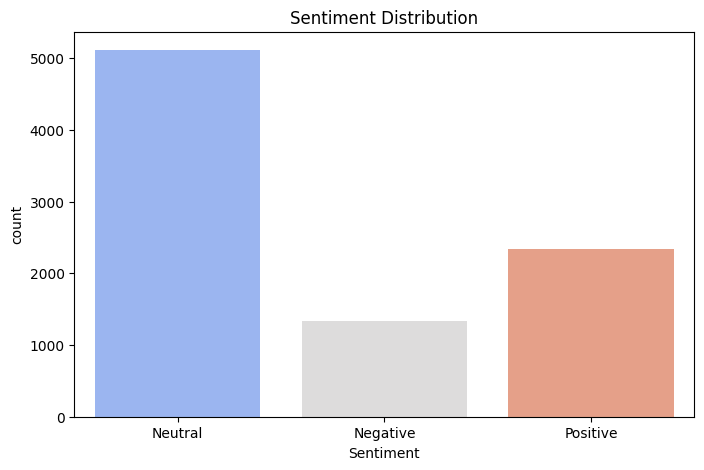

In [99]:
plt.figure(figsize=(8,5))
sns.countplot(x=df["Sentiment"], palette="coolwarm")
plt.title("Sentiment Distribution")
plt.show()

In [100]:
sentiment_by_subreddit = df.groupby("Subreddit")["Sentiment"].value_counts().unstack()
print(sentiment_by_subreddit)

Sentiment              Negative  Neutral  Positive
Subreddit                                         
Bitcoin                     375     1594       780
BitcoinMarkets               33     1065        58
CryptoCurrencyTrading       112      396       240
btc                         344     1116       642
cryptocurrency              476      940       615


### Generate Word Clouds

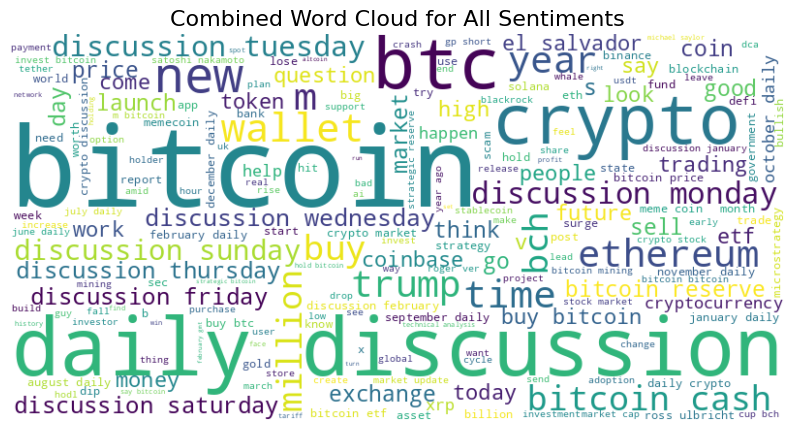

In [101]:
# Combine all cleaned text into one string
combined_text = ' '.join(df['cleaned_text'])

# Generate a single word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Plot the combined word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Combined Word Cloud for All Sentiments', fontsize=16)
plt.show()

### Compare VADER sentiment scores with the actual text content.

In [102]:
# Function to get VADER sentiment score
def get_vader_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply VADER sentiment analysis
df["VADER_Sentiment"] = df["cleaned_text"].astype(str).apply(get_vader_sentiment)

# Compare actual sentiment vs. VADER's predicted sentiment
comparison_df = df[["cleaned_text", "Sentiment", "VADER_Sentiment"]].sample(10)  # Select random 10 samples for comparison

# Display comparison
print(comparison_df)

                                           cleaned_text Sentiment  \
2548                                   new bitcoin high   Neutral   
7395                                                  k   Neutral   
2595  send bitcoin transaction nervous learn s happe...  Negative   
2971  bitcoin worth b leave centralized exchange big...  Positive   
3306        crypto market confusing lose logic   trader  Negative   
5351           bold bitcoin prediction     price double  Positive   
1783                          bitcoin break away crypto   Neutral   
184                                              wisdom  Positive   
4402  gold maxi change mind crypto create   million ...  Positive   
6228                           steal seed phrase happen  Negative   

     VADER_Sentiment  
2548         Neutral  
7395         Neutral  
2595        Negative  
2971        Positive  
3306        Negative  
5351        Positive  
1783         Neutral  
184         Positive  
4402        Positive  
6228      

## ML Pipeline:

### Feature Extraction:
**Text Vectorization**

Text data needs to be transformed into numerical format since machine learning models cannot directly work with text.

I will choose TF-IDF (Term Frequency-Inverse Document Frequency) because it reflects how important a word is within a document and across the entire dataset. This is particularly useful for capturing the essence of a text review without giving too much importance to common words (like "the", "is", etc.).

TF-IDF Explanation:

TF (Term Frequency): Measures how frequently a word appears in a document.
IDF (Inverse Document Frequency): Measures how common or rare a word is across all documents. Rare words are given higher weightage.

In [103]:
# Initialize TfidfVectorizer: Limit to top 1000 words
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df["cleaned_text"])

In [104]:
#Convert to DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print(tfidf_df.head())

   accelerate  accept  access  accord  account  accumulation  achieve  \
0         0.0     0.0     0.0     0.0      0.0           0.0      0.0   
1         0.0     0.0     0.0     0.0      0.0           0.0      0.0   
2         0.0     0.0     0.0     0.0      0.0           0.0      0.0   
3         0.0     0.0     0.0     0.0      0.0           0.0      0.0   
4         0.0     0.0     0.0     0.0      0.0           0.0      0.0   

   acquire  action  active  ...  world  worth  wow  wrap  wrong  xrp  year  \
0      0.0     0.0     0.0  ...    0.0    0.0  0.0   0.0    0.0  0.0   0.0   
1      0.0     0.0     0.0  ...    0.0    0.0  0.0   0.0    0.0  0.0   0.0   
2      0.0     0.0     0.0  ...    0.0    0.0  0.0   0.0    0.0  0.0   0.0   
3      0.0     0.0     0.0  ...    0.0    0.0  0.0   0.0    0.0  0.0   0.0   
4      0.0     0.0     0.0  ...    0.0    0.0  0.0   0.0    0.0  0.0   0.0   

   yen  yield  young  
0  0.0    0.0    0.0  
1  0.0    0.0    0.0  
2  0.0    0.0    0.0  


In [105]:
# Encode sentiment labels into numeric values
label_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
df["Sentiment_Num"] = df["Sentiment"].map(label_map)

In [106]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, df["Sentiment_Num"], test_size=0.2, random_state=42
)

In [107]:
# Verify the shapes of the training and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (7028, 1000)
Test set shape: (1758, 1000)


### Logistic Regression

In [110]:
# Initialize and train the Logistic Regression model with balanced class weights
lr_model = LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear')
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, solver='liblinear')

### Handling Class Imbalance

To deal with class imbalance, I adjusted the Logistic Regression model by setting the `class_weight` parameter to `'balanced'`. This approach automatically adjusts the weights inversely proportional to the class frequencies, ensuring that the model gives more emphasis to the minority classes.

In [111]:
# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

In [112]:
# Evaluate Logistic Regression performance
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.8344709897610921
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       266
           1       0.86      0.92      0.89      1037
           2       0.84      0.73      0.78       455

    accuracy                           0.83      1758
   macro avg       0.81      0.77      0.79      1758
weighted avg       0.83      0.83      0.83      1758



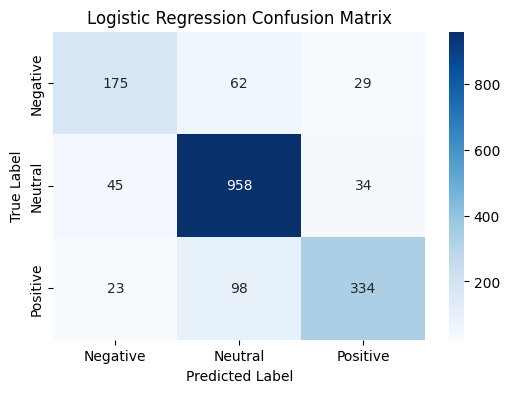

In [113]:
# Visualize the confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

### Random Forest Pipeline

In [114]:
# Initialize and train the Random Forest model with balanced class weights
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [115]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

In [116]:
# Evaluate Random Forest performance
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9220705346985211
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       266
           1       0.91      0.98      0.94      1037
           2       0.97      0.85      0.90       455

    accuracy                           0.92      1758
   macro avg       0.93      0.88      0.90      1758
weighted avg       0.92      0.92      0.92      1758



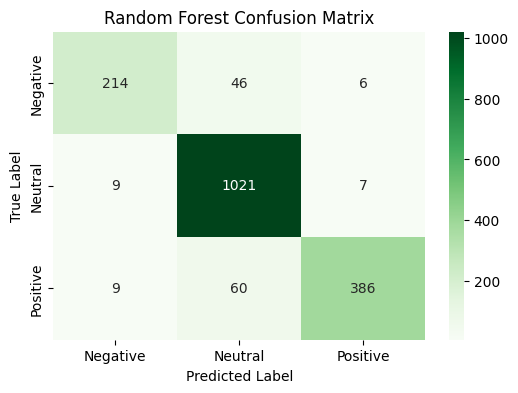

In [117]:
# Visualize the confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()